## CNN en utilisant la Fenêtre glissante

In [1]:
from tensorflow.keras import  layers ,optimizers,models,regularizers
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import holidays





## CNN  pour toute stations

In [2]:
file_path = 'merged_all_bikes_weather_events.csv'
data = pd.read_csv(file_path)
# prepa de data, add time categorie
country_holidays = holidays.CountryHoliday('FR')
data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  
data['not_work'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['minute'] = data['timestamp'].dt.minute
data['date'] = data['timestamp'].dt.date          
data['is_holiday'] = data['date'].apply(lambda x: 1 if x in country_holidays else 0)
data['is_non_working'] = data.apply(lambda row: 1 if row['not_work'] == 1 or row['is_holiday'] == 1 else 0, axis=1)
data = data.drop(columns=['day_of_week','not_work','date','is_holiday'])
print(data.columns.tolist())






['timestamp', 'number', 'status', 'available_bike_stands', 'available_bikes', 'visibility_distance', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'snow', 'wind_speed', 'counter_events', 'hour', 'minute', 'is_non_working']


In [3]:


## test, val, split :
train_ratio = 0.7
valid_ratio = 0.1
X_train, y_train = [], []
X_valid, y_valid = [], []
X_test, y_test = [], []
T=4

def create_sliding_window(values, window_size,available_bikes_index):
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size][available_bikes_index])  #  'available_bikes'
    return np.array(X), np.array(y)
for station, group in data.groupby('number'):
    group = group.sort_values('timestamp')
    group= group.drop(columns='timestamp')
    available_bikes_index = data.columns.tolist().index('available_bikes')
    values = group.values  
    
    train_end = int(len(values) * train_ratio)
    valid_end = int(len(values) * (train_ratio + valid_ratio))

    train_values = values[:train_end]
    valid_values = values[train_end:valid_end]
    test_values = values[valid_end:]


    X_t, y_t = create_sliding_window(train_values, T,available_bikes_index)
    X_v, y_v = create_sliding_window(valid_values, T,available_bikes_index)
    X_te, y_te = create_sliding_window(test_values, T,available_bikes_index)

    if len(X_t) > 0:
        X_train.append(X_t)
        y_train.append(y_t)
    if len(X_v) > 0:
        X_valid.append(X_v)
        y_valid.append(y_v)
    if len(X_te) > 0:
        X_test.append(X_te)
        y_test.append(y_te)
X_train = np.vstack(X_train)
y_train = np.hstack(y_train)
X_valid = np.vstack(X_valid)
y_valid = np.hstack(y_valid)
X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

print("\n X_train shape:", X_train.shape)
print("X_val shape：", X_valid.shape)
print("X_test shape：", X_test.shape)

print("\ny_train shape：", y_train.shape)
print("y_val shape：", y_valid.shape)
print("y_test shape：", y_test.shape)






 X_train shape: (825593, 4, 14)
X_val shape： (116581, 4, 14)
X_test shape： (235066, 4, 14)

y_train shape： (825593,)
y_val shape： (116581,)
y_test shape： (235066,)


In [4]:
# traite data train test
standardScale_feature=['visibility_distance','current_temperature','feels_like_temperature','wind_speed','counter_events','available_bikes']
inchange_feature=['minute','hour','is_non_working','is_rainy','number','status']
scalers = {}
standardScale_indices = [data.columns.tolist().index(feat) for feat in standardScale_feature]
def scale_features(X, scalers, standardScale_indices, train=True):
    for idx in standardScale_indices:
        if train:
            scalers[idx] = StandardScaler()
            X[:, :, idx] = scalers[idx].fit_transform(X[:, :, idx])
        else:
            X[:, :, idx] = scalers[idx].transform(X[:, :, idx])
    return X
X_train = scale_features(X_train, scalers, standardScale_indices, train=True)

X_valid = scale_features(X_valid, scalers, standardScale_indices, train=False)

X_test = scale_features(X_test, scalers, standardScale_indices, train=False)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_valid = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("\n X_train shape:", X_train.shape)
print("X_val shape：", X_valid.shape)
print("X_test shape：", X_test.shape)

print("\ny_train shape：", y_train.shape)
print("y_val shape：", y_valid.shape)
print("y_test shape：", y_test.shape)



 X_train shape: (825593, 4, 14)
X_val shape： (116581, 4, 14)
X_test shape： (235066, 4, 14)

y_train shape： (825593,)
y_val shape： (116581,)
y_test shape： (235066,)


In [5]:
model = models.Sequential([
    layers.Conv1D(filters=32,  
                  kernel_size=2, 
                  activation='relu', 
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  kernel_regularizer=regularizers.l2(0.001)),  
    
    layers.BatchNormalization(),  
    layers.MaxPooling1D(pool_size=2, strides=1),
    layers.Dropout(0.1),
    
    layers.Conv1D(
            filters=64,
            kernel_size=2,
            activation='relu',
             padding='VALID',
            kernel_regularizer=regularizers.l2(0.001)
        ),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Flatten(),

    layers.Dense(128, activation='relu'),  
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             928       
                                                                 
 batch_normalization (Batch  (None, 3, 32)             128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64)             2

In [6]:
from tensorflow.keras import callbacks
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=128,
    shuffle=False,
    callbacks=[callbacks] 
)



Training the model...
Epoch 1/30
6450/6450 [==============================] - 63s 9ms/step - loss: 0.7236 - mae: 0.6385 - val_loss: 0.7008 - val_mae: 0.6600 - lr: 0.0010
Epoch 2/30
6450/6450 [==============================] - 55s 8ms/step - loss: 0.6381 - mae: 0.6095 - val_loss: 0.6885 - val_mae: 0.6046 - lr: 0.0010
Epoch 3/30
6450/6450 [==============================] - 55s 9ms/step - loss: 0.6338 - mae: 0.6076 - val_loss: 5.8680 - val_mae: 2.3993 - lr: 0.0010
Epoch 4/30
6450/6450 [==============================] - 58s 9ms/step - loss: 0.6350 - mae: 0.6085 - val_loss: 1.3978 - val_mae: 1.1517 - lr: 0.0010
Epoch 5/30
6450/6450 [==============================] - 62s 10ms/step - loss: 0.6268 - mae: 0.6037 - val_loss: 7.5270 - val_mae: 2.2208 - lr: 2.0000e-04


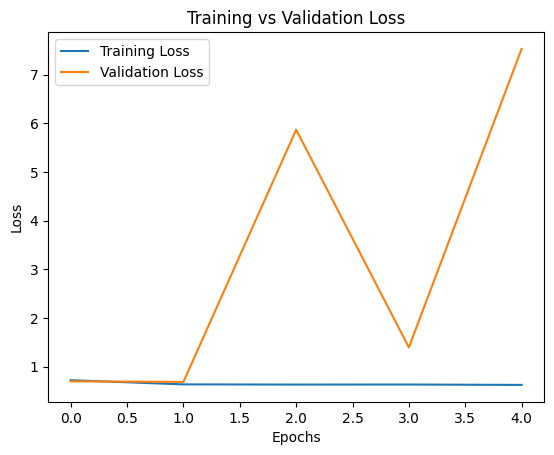

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [11]:
predictions = model.predict( X_test)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'\nModel Performance:')
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')


7346/7346 [==============================] - 18s 2ms/step

Model Performance:
R² Score: -11.4959
MAE: 0.6082


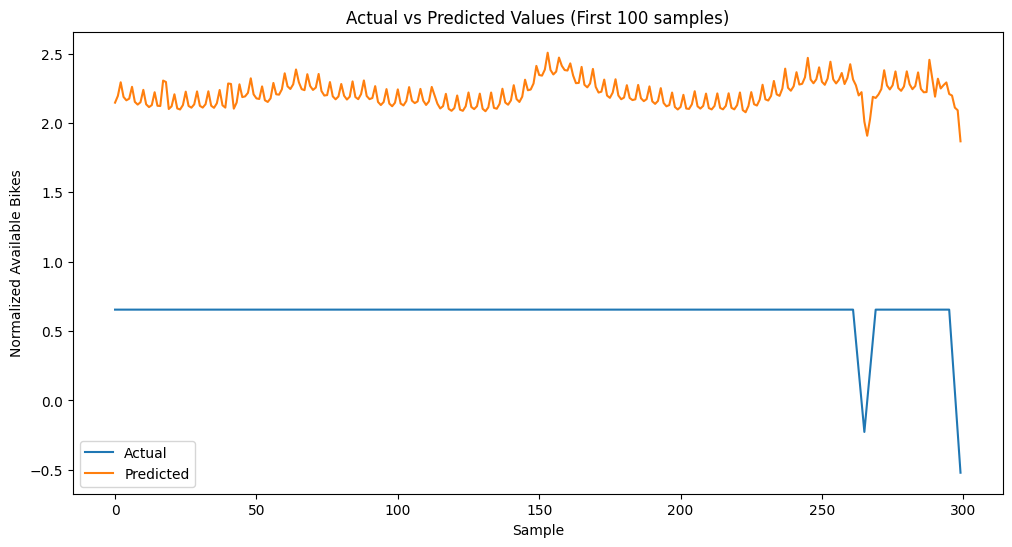

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(y_test[:300], label='Actual')
plt.plot(predictions[:300], label='Predicted')
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()

LSTM

train shape: (911737, 4, 15)
test shape: (227076, 4, 15)
Epoch 1/30
11397/11397 [==============================] - 347s 29ms/step - loss: 0.0077 - mae: 0.0592 - val_loss: 0.0053 - val_mae: 0.0593 - lr: 0.0010
Epoch 2/30
11397/11397 [==============================] - 275s 24ms/step - loss: 0.0041 - mae: 0.0477 - val_loss: 0.0023 - val_mae: 0.0368 - lr: 0.0010
Epoch 3/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0037 - mae: 0.0445 - val_loss: 0.0028 - val_mae: 0.0427 - lr: 0.0010
Epoch 4/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0030 - val_mae: 0.0435 - lr: 0.0010
Epoch 5/30
11397/11397 [==============================] - 315s 28ms/step - loss: 0.0033 - mae: 0.0422 - val_loss: 0.0024 - val_mae: 0.0370 - lr: 0.0010
Epoch 6/30
11397/11397 [==============================] - 325s 28ms/step - loss: 0.0033 - mae: 0.0420 - val_loss: 0.0032 - val_mae: 0.0431 - lr: 5.0000e-04
Epoch 7/30
11397/11397 [===

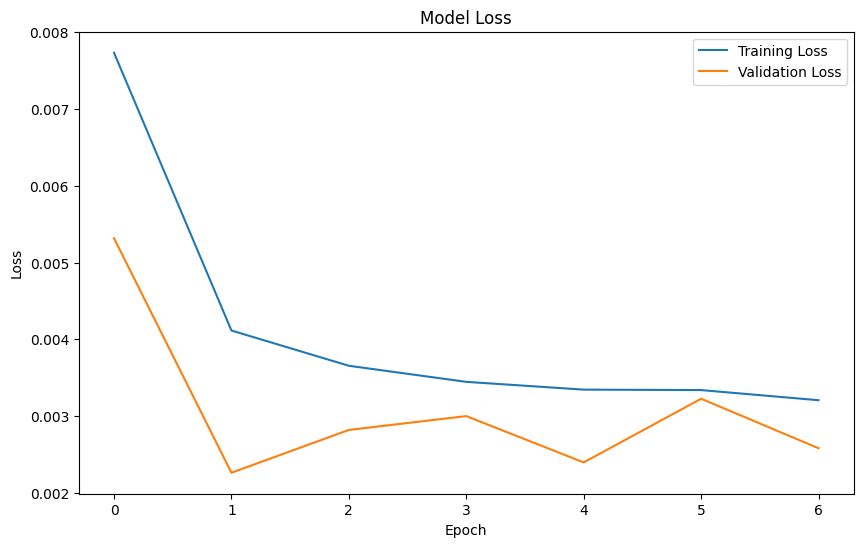

7097/7097 [==============================] - 57s 8ms/step

Model Performance:
R² Score: -0.9638
MAE: 0.1052


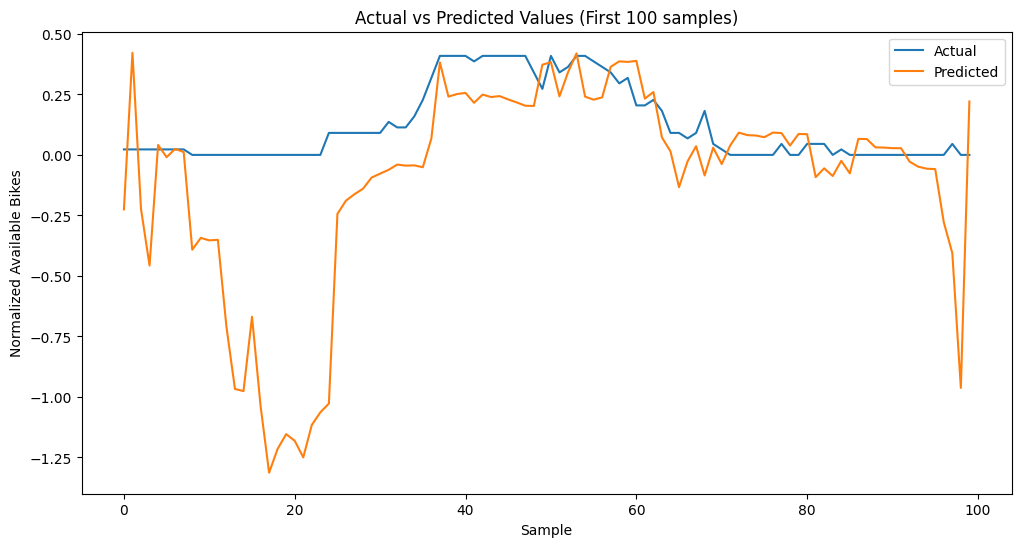

In [15]:
def create_sequences(data, window_size, target_col='available_bikes'):
    X = []
    y = []
    grouped = data.groupby('number')
    
    for _, group in grouped:
        group = group.sort_index()
        sequences = []
        targets = []
        
        for i in range(len(group) - window_size):
            sequences.append(group.iloc[i:i + window_size].values)
            targets.append(group.iloc[i + window_size][target_col])
            
        X.extend(sequences)
        y.extend(targets)
    
    return np.array(X), np.array(y)
X_train, y_train = create_sequences(train_data, 4)
X_test, y_test = create_sequences(test_data, 4)
print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks_list,
        shuffle=False
    )

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'\nModel Performance:')
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()